In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import pickle

import matplotlib 
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def client_update(client_model, optimizer, train_loader, epoch, num_clients, pk, batch_size):
    client_model.train()
    Grad_accumulator = []
    for e in range(epoch):
        grad_batch_idx = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = client_model(data)
            loss_fed = F.nll_loss(output, target)
            loss = loss_fed/(epoch *num_clients*pk)
            loss.backward()
            #print(type(client_model))
            #print(dir(client_model))
#             print(client_model.parameters())
#             grad_batch_idx.append(client_model.parameters().grad.numpy()) 
#             grad_batch_idx.append(list(i.grad for i in list(client_model.parameters())))
            if Grad_accumulator == []:
                Grad_accumulator = list(i.grad for i in list(client_model.parameters()))
                    
            else:
                h = list(i.grad for i in list(client_model.parameters()))
                Grad_accumulator = [Grad_accumulator[i]+h[i] for i in range(len(Grad_accumulator))]
            optimizer.step()
#         grad_batch_idx_np = np.array(grad_batch_idx)
#         grad_batch_e = sum(grad_batch_idx_np)/len(grad_batch_idx_np)
#         grad_epoch.append(grad_batch_e)
#     grad_client = sum(grad_epoch)/epoch 
#     grad_client_tensor = torch.from_numpy(grad_client)
    
    nabla_P_norm2 = sum([(torch.norm(a))**2 for a in Grad_accumulator]).item()
    grad_client = (1/(epoch*batch_size))*np.sqrt(nabla_P_norm2)
    return loss_fed.item(),grad_client


def client_update_fed(client_model, optimizer, train_loader, epoch):
    client_model.train()
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = client_model(data)
            loss = F.nll_loss(output, target)/epoch
            loss.backward()
            optimizer.step()
    return loss.item()

def server_aggregate(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k] for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

def test(global_model, test_loader):
    global_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = global_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    return test_loss, acc


0-th round
average train loss 2.14 | test loss 2.31 | test acc: 0.098
1-th round
average train loss 2.09 | test loss 2.3 | test acc: 0.097
2-th round
average train loss 1.95 | test loss 2.3 | test acc: 0.097
3-th round
average train loss 1.37 | test loss 2.3 | test acc: 0.135
4-th round
average train loss 0.992 | test loss 2.34 | test acc: 0.185
5-th round
average train loss 0.591 | test loss 2.27 | test acc: 0.207
6-th round
average train loss 0.545 | test loss 2.27 | test acc: 0.260
7-th round
average train loss 0.427 | test loss 2.47 | test acc: 0.176
8-th round
average train loss 0.345 | test loss 2.22 | test acc: 0.248
9-th round
average train loss 0.331 | test loss 2.1 | test acc: 0.201
10-th round
average train loss 0.268 | test loss 2.54 | test acc: 0.194
11-th round
average train loss 0.189 | test loss 2.25 | test acc: 0.232
12-th round
average train loss 0.156 | test loss 2.52 | test acc: 0.195
13-th round
average train loss 0.231 | test loss 2.04 | test acc: 0.213
14-th roun

113-th round
average train loss 0.0452 | test loss 0.71 | test acc: 0.735
114-th round
average train loss 0.0229 | test loss 0.59 | test acc: 0.813
115-th round
average train loss 0.0307 | test loss 0.815 | test acc: 0.733
116-th round
average train loss 0.0369 | test loss 0.819 | test acc: 0.709
117-th round
average train loss 0.0449 | test loss 0.782 | test acc: 0.698
118-th round
average train loss 0.0276 | test loss 0.732 | test acc: 0.759
119-th round
average train loss 0.0625 | test loss 0.734 | test acc: 0.742
120-th round
average train loss 0.0281 | test loss 0.566 | test acc: 0.817
121-th round
average train loss 0.0276 | test loss 0.792 | test acc: 0.716
122-th round
average train loss 0.0496 | test loss 0.722 | test acc: 0.732
123-th round
average train loss 0.0443 | test loss 0.787 | test acc: 0.715
124-th round
average train loss 0.0367 | test loss 0.762 | test acc: 0.753
125-th round
average train loss 0.0393 | test loss 0.599 | test acc: 0.792
126-th round
average train 

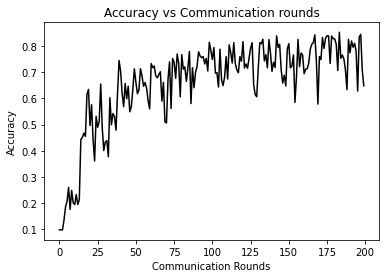

In [4]:
# NON-IID case: every client has images of two categories chosen from [0, 1], [2, 3], [4, 5], [6, 7], or [8, 9].

# Hyperparameters

num_clients = 100
num_selected = 10
num_rounds = 200
epochs = 10
batch_size = 32
local_ep_list = np.random.choice(range(1,epochs+1),size=num_clients)
lr = 0.01
# Creating decentralized datasets

traindata = datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
                       )
target_labels = torch.stack([traindata.targets == i for i in range(10)])
target_labels_split = []
for i in range(5):
    target_labels_split += torch.split(torch.where(target_labels[(2 * i):(2 * (i + 1))].sum(0))[0], int(60000 / num_clients))
traindata_split = [torch.utils.data.Subset(traindata, tl) for tl in target_labels_split]
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
        ), batch_size=batch_size, shuffle=True)

# Instantiate models and optimizers

global_model = Net().cuda()
client_models = [Net().cuda() for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())
# print(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=lr) for model in client_models]
# opt = optim.SGD(model.parameters(), lr=0.01) 
                 
# Runnining FL
p_initial = np.ones(num_clients)/num_clients # initialize the probability vector
p_usersampling = p_initial
        
test_loss_accu=[]
acc_accu = []
for r in range(num_rounds):
    # select random clients
#     client_idx = np.random.permutation(num_clients)[:num_selected]
    client_idx = np.random.choice(range(num_clients), num_selected, replace=False,p = p_usersampling)
 
    # client update
#     loss = 0
#     grad_client = 0
    grad_list=[]
    loss_list=[]
    for i in range(num_selected):
        loss,grad_client = client_update(client_models[i], opt[i], train_loader[client_idx[i]], 
                              epoch=int(local_ep_list[client_idx[i]]), num_clients=num_clients, pk=p_usersampling[client_idx[i]], batch_size=batch_size )
        grad_list.append(grad_client)
        loss_list.append(loss)
    loss = sum(loss_list)
    
    grad_list = [a/sum(grad_list) for a in grad_list]
    normalizing_factor = sum([p_usersampling[i] for i in client_idx])
    
    for i in range(num_selected):
        p_usersampling[client_idx[i]]=(grad_list[i]/sum(grad_list)) * normalizing_factor
    # serer aggregate
    server_aggregate(global_model, client_models)
    test_loss, acc = test(global_model, test_loader)
    test_loss_accu.append(test_loss)
    acc_accu.append(acc)
                 
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_selected, test_loss, acc))
#     print('sampling probability:' )
#     print(p_usersampling)
                 
file_name = './save/objects/fedsample_Epoch{}_lr{}_loss_and_acc.pkl'. \
                format(epochs, lr)
with open(file_name, 'wb') as f:
            pickle.dump([test_loss_accu, acc_accu.append], f)
                 
# Plot Average Accuracy vs Communication rounds
plt.figure()
plt.title('Accuracy vs Communication rounds')
plt.plot(range(len(acc_accu)), acc_accu, color='k')
plt.ylabel('Accuracy')
plt.xlabel('Communication Rounds')
plt.savefig('./save/fedsample_diffEpoch{}_lr{}_acc.png'.
                format(epochs, lr))             

0-th round
average train loss 0.52 | test loss 2.3 | test acc: 0.089
1-th round
average train loss 0.474 | test loss 2.3 | test acc: 0.125
2-th round
average train loss 0.574 | test loss 2.29 | test acc: 0.139
3-th round
average train loss 0.528 | test loss 2.29 | test acc: 0.158
4-th round
average train loss 0.301 | test loss 2.3 | test acc: 0.179
5-th round
average train loss 0.287 | test loss 2.25 | test acc: 0.337
6-th round
average train loss 0.155 | test loss 2.62 | test acc: 0.167
7-th round
average train loss 0.108 | test loss 3.03 | test acc: 0.178
8-th round
average train loss 0.175 | test loss 2.01 | test acc: 0.434
9-th round
average train loss 0.0628 | test loss 2.67 | test acc: 0.194
10-th round
average train loss 0.039 | test loss 2.66 | test acc: 0.326
11-th round
average train loss 0.0573 | test loss 2.16 | test acc: 0.261
12-th round
average train loss 0.0353 | test loss 1.7 | test acc: 0.338
13-th round
average train loss 0.038 | test loss 1.87 | test acc: 0.317
14-t

112-th round
average train loss 0.0192 | test loss 0.648 | test acc: 0.790
113-th round
average train loss 0.00782 | test loss 0.7 | test acc: 0.758
114-th round
average train loss 0.00904 | test loss 0.699 | test acc: 0.769
115-th round
average train loss 0.00466 | test loss 0.558 | test acc: 0.821
116-th round
average train loss 0.00421 | test loss 0.777 | test acc: 0.747
117-th round
average train loss 0.0135 | test loss 0.728 | test acc: 0.728
118-th round
average train loss 0.0182 | test loss 0.735 | test acc: 0.746
119-th round
average train loss 0.0137 | test loss 0.934 | test acc: 0.678
120-th round
average train loss 0.0185 | test loss 0.546 | test acc: 0.825
121-th round
average train loss 0.00658 | test loss 0.525 | test acc: 0.840
122-th round
average train loss 0.00997 | test loss 0.715 | test acc: 0.765
123-th round
average train loss 0.0104 | test loss 0.615 | test acc: 0.806
124-th round
average train loss 0.0137 | test loss 0.681 | test acc: 0.751
125-th round
average 

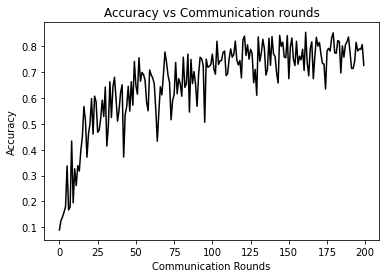

In [6]:
# NON-IID case: every client has images of two categories chosen from [0, 1], [2, 3], [4, 5], [6, 7], or [8, 9].

# Hyperparameters

num_clients = 100
num_selected = 10
num_rounds = 200
epochs = 10
batch_size = 32
local_ep_list = np.random.choice(range(1,epochs+1),size=num_clients)
lr = 0.01
# Creating decentralized datasets

traindata = datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
                       )
target_labels = torch.stack([traindata.targets == i for i in range(10)])
target_labels_split = []
for i in range(5):
    target_labels_split += torch.split(torch.where(target_labels[(2 * i):(2 * (i + 1))].sum(0))[0], int(60000 / num_clients))
traindata_split = [torch.utils.data.Subset(traindata, tl) for tl in target_labels_split]
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
        ), batch_size=batch_size, shuffle=True)

# Instantiate models and optimizers

global_model = Net().cuda()
client_models = [Net().cuda() for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())
# print(global_model.state_dict())


opt = [optim.SGD(model.parameters(), lr=lr) for model in client_models]

# Runnining FL
test_loss_accu1 = []
acc_accu1 = []
for r in range(num_rounds):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]

    # client update
    loss = 0
    for i in range(num_selected):
        loss += client_update_fed(client_models[i], opt[i], train_loader[client_idx[i]], epoch=int(local_ep_list[client_idx[i]]))
    
    # serer aggregate
    server_aggregate(global_model, client_models)
    test_loss, acc = test(global_model, test_loader)
    test_loss_accu1.append(test_loss)
    acc_accu1.append(acc)
    
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_selected, test_loss, acc))
    
file_name = './save/objects/fed_diffEpoch{}_lr{}_loss_and_acc.pkl'. \
                format(epochs, lr)
with open(file_name, 'wb') as f:
            pickle.dump([test_loss_accu1, acc_accu1], f)
    
# Plot Average Accuracy vs Communication rounds
plt.figure()
plt.title('Accuracy vs Communication rounds')
plt.plot(range(len(acc_accu1)), acc_accu1, color='k')
plt.ylabel('Accuracy')
plt.xlabel('Communication Rounds')
plt.savefig('./save/fed_diffEpoch{}_lr{}_acc.png'.
                format(epochs, lr))

0-th round
average train loss 0.427 | test loss 2.3 | test acc: 0.102
1-th round
average train loss 0.402 | test loss 2.3 | test acc: 0.101
2-th round
average train loss 0.368 | test loss 2.29 | test acc: 0.138
3-th round
average train loss 0.234 | test loss 2.29 | test acc: 0.174
4-th round
average train loss 0.135 | test loss 2.33 | test acc: 0.103
5-th round
average train loss 0.117 | test loss 2.36 | test acc: 0.108
6-th round
average train loss 0.0782 | test loss 2.38 | test acc: 0.197
7-th round
average train loss 0.08 | test loss 2.3 | test acc: 0.173
8-th round
average train loss 0.0592 | test loss 2.06 | test acc: 0.204
9-th round
average train loss 0.049 | test loss 2.52 | test acc: 0.192
10-th round
average train loss 0.0403 | test loss 2.24 | test acc: 0.189
11-th round
average train loss 0.0295 | test loss 2.03 | test acc: 0.351
12-th round
average train loss 0.0289 | test loss 1.65 | test acc: 0.611
13-th round
average train loss 0.0169 | test loss 1.87 | test acc: 0.505


112-th round
average train loss 0.00471 | test loss 1.03 | test acc: 0.642
113-th round
average train loss 0.0106 | test loss 0.832 | test acc: 0.714
114-th round
average train loss 0.00699 | test loss 0.955 | test acc: 0.683
115-th round
average train loss 0.00458 | test loss 0.939 | test acc: 0.683
116-th round
average train loss 0.0116 | test loss 0.953 | test acc: 0.672
117-th round
average train loss 0.00555 | test loss 0.969 | test acc: 0.704
118-th round
average train loss 0.0155 | test loss 0.762 | test acc: 0.734
119-th round
average train loss 0.0105 | test loss 0.949 | test acc: 0.670
120-th round
average train loss 0.0149 | test loss 1.07 | test acc: 0.680
121-th round
average train loss 0.00867 | test loss 0.97 | test acc: 0.690
122-th round
average train loss 0.00236 | test loss 0.754 | test acc: 0.732
123-th round
average train loss 0.0069 | test loss 0.784 | test acc: 0.741
124-th round
average train loss 0.00986 | test loss 0.93 | test acc: 0.675
125-th round
average t

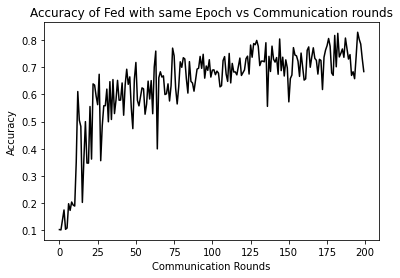

In [8]:
# NON-IID case: every client has images of two categories chosen from [0, 1], [2, 3], [4, 5], [6, 7], or [8, 9].

# Hyperparameters

num_clients = 100
num_selected = 10
num_rounds = 200
epochs = 5
batch_size = 32
lr = 0.01

# Creating decentralized datasets

traindata = datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
                       )
target_labels = torch.stack([traindata.targets == i for i in range(10)])
target_labels_split = []
for i in range(5):
    target_labels_split += torch.split(torch.where(target_labels[(2 * i):(2 * (i + 1))].sum(0))[0], int(60000 / num_clients))
traindata_split = [torch.utils.data.Subset(traindata, tl) for tl in target_labels_split]
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
        ), batch_size=batch_size, shuffle=True)

# Instantiate models and optimizers

global_model = Net().cuda()
client_models = [Net().cuda() for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=lr) for model in client_models]

# Runnining FL
test_loss_accu2=[]
acc_accu2 = []
for r in range(num_rounds):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]

    # client update
    loss = 0
    for i in range(num_selected):
        loss += client_update_fed(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)
    
    # serer aggregate
    server_aggregate(global_model, client_models)
    test_loss, acc = test(global_model, test_loader)
    test_loss_accu2.append(test_loss)
    acc_accu2.append(acc)
    
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_selected, test_loss, acc))
    
file_name = './save/objects/fed_sameEpoch{}_lr{}_loss_and_acc.pkl'. \
                format(epochs, lr)
with open(file_name, 'wb') as f:
            pickle.dump([test_loss_accu2, acc_accu2], f)


# Plot Average Accuracy vs Communication rounds
plt.figure()
plt.title('Accuracy of Fed with same Epoch vs Communication rounds')
plt.plot(range(len(acc_accu2)), acc_accu2, color='k')
plt.ylabel('Accuracy')
plt.xlabel('Communication Rounds')
plt.savefig('./save/fed_sameEpoch{}_lr{}_acc.png'.
                format(epochs, lr))

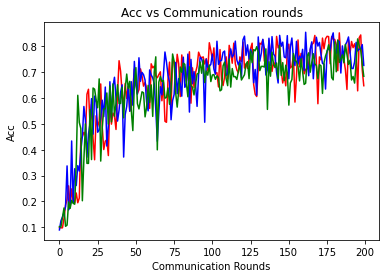

In [9]:
plt.figure()
plt.title('Acc vs Communication rounds')
plt.plot(range(len(acc_accu)), acc_accu, color='r', label='importance')
plt.plot(range(len(acc_accu1)), acc_accu1,color='b', label='uniform')
plt.plot(range(len(acc_accu2)), acc_accu2,color='g', label='Fed-uniform-uniformE')
plt.ylabel('Acc')
plt.xlabel('Communication Rounds')
plt.savefig('./save/fed_acc_Epoch{}_lr{}_acc.png'.
                format(epochs, lr))

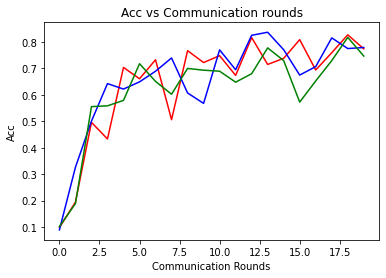

In [12]:
acc_accu_tune = [acc_accu[i] for i in range(0,len(acc_accu),10)]
acc_accu_tune1 = [acc_accu1[i] for i in range(0,len(acc_accu1),10)]
acc_accu_tune2 = [acc_accu2[i] for i in range(0,len(acc_accu2),10)]

plt.figure()
plt.title('Acc vs Communication rounds')
plt.plot(range(len(acc_accu_tune)), acc_accu_tune, color='r', label='importance')
plt.plot(range(len(acc_accu_tune1)), acc_accu_tune1,color='b', label='uniform')
plt.plot(range(len(acc_accu_tune2)), acc_accu_tune2,color='g', label='Fed-uniform-uniformE')
plt.ylabel('Acc')
plt.xlabel('Communication Rounds')
plt.savefig('./save/tune10_fed_acc_Epoch{}_lr{}_acc.png'.
                format(epochs, lr))